In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os

os.sys.path.append("../")

# DBSCAN Primary vertexing in 3 Dimensions!

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import seaborn as sns

hep.style.use("CMS")

In [4]:
from primaryvertexingtools import PrimaryVertexing, PerformanceMetrics

In [5]:
storage = "/home/lucas/Documents/RA/data/"
tt = pd.read_parquet(storage + "ttbar_50k.parquet")
tt_mc = pd.read_parquet(storage + "ttbar_mc_50k.parquet")

In [7]:
tt["entry"] = tt["event_number"]
tt["subentry"] = tt["track_number"]
tt.set_index(["entry", "subentry"], inplace=True)
tt_mc["entry"] = tt_mc["event_number"]
tt_mc["subentry"] = tt_mc["track_number"]
tt_mc.set_index(["entry", "subentry"], inplace=True)
tt["is_pv"] = 0
tt.loc[tt["trk_fake"] == 1, "is_pv"] = 1
tt.dropna(inplace=True)

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
sc = StandardScaler()

In [29]:
X_sc = sc.fit_transform(tt[["trk_z0", "trk_eta", "trk_phi"]])

In [30]:
X_sc

array([[ 0.52,  1.09, -0.18],
       [-2.5 ,  1.31, -0.14],
       [-0.83,  0.46, -0.05],
       ...,
       [-0.8 ,  1.63, -0.63],
       [ 1.78, -1.59, -0.38],
       [ 0.75, -1.74, -0.28]], dtype=float32)

In [31]:
X_sc[:, 0]

array([ 0.52, -2.5 , -0.83, ..., -0.8 ,  1.78,  0.75], dtype=float32)

In [32]:
tt["trk_z0_sc"] = X_sc[:, 0]
tt["trk_eta_sc"] = X_sc[:, 1]
tt["trk_phi_sc"] = X_sc[:, 2]

In [ ]:
tts_mc

In [50]:
tt.head()

event_number  track_number    trk_pt   trk_eta     trk_z0  \
entry subentry                                                              
0     0                    0             0  3.321735  1.508114   2.285156   
      1                    0             1  2.802182  1.816592 -10.957031   
      2                    0             2  2.178730  0.647218  -3.632812   
      3                    0             3  1.971232  1.026682  -1.406250   
      4                    0             4  1.974080 -1.409943  -1.582031   

                 trk_phi  trk_fake  trk_MVA1  trk_chi2_x  trk_chi2_y  ...  \
entry subentry                                                        ...   
0     0        -0.322148         2  0.999705    3.449683    3.449683  ...   
      1        -0.262414         2  0.996890    4.947418    4.947418  ...   
      2        -0.083509         2  0.990228   11.213161   11.213161  ...   
      3         0.047079         2  0.996147    3.593802    3.593802  ...   
      4         0.263590         2  0.998664   12.148260   12.148260  ...   

                trk_bendchi2  trk_MVA2  trk_nstub  trk_lhits  trk_dhits  \
entry subentry                                                            
0     0             0.650641       0.0          6        111       1011   
      1             1.399517       0.0          6         11       1111   
      2             1.053935       0.0          6     111111          0   
      3             0.702030       0.0          5      11111          0   
      4             1.077325       0.0          6        111        111   

                trk_seed  is_pv  trk_z0_sc  trk_eta_sc  trk_phi_sc  
entry subentry                                                      
0     0                0      0   0.520197    1.086518   -0.176605  
      1                0      0  -2.500710    1.309374   -0.143670  
      2                0      0  -0.829855    0.464573   -0.045030  
      3                0      0  -0.321914    0.738712    0.026970  
      4                0      0  -0.362015   -1.021599    0.146345  

[5 rows x 23 columns]

In [51]:
tt_pv = PrimaryVertexing(
    {
        "track_data": tt,
        "truth_data": tt_mc,
        "fh_bins": np.linspace(-15, 15, 256),
        "test_run": True,
        "nevents_test": 2000,
        "rank_by_pt": False,
    }
)

Initialized Primary Vertexing setup


In [52]:
tt_pv.run_fh()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:00<00:00, 4077.17it/s]


Ran Fast Histo


In [53]:
X_sc.std(axis=0)

array([1., 1., 1.], dtype=float32)

In [58]:
tt_pv.run_dbscan(stat="median", is_3d=True, norm=True, eps=0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 237.70it/s]

Ran DBSCAN with eps: 0.1, minPts: 2


In [59]:
tt_pm = PerformanceMetrics(tt_pv)

0.124622345
positive bias 0.03300488
negative bias -0.03620684


In [60]:
tt_pm.pv_efficiency((tt_pm.z0_gen - tt_pm.z0_reco_fh_cor), display=True)

72.81 %


In [63]:
tt_pm.pv_efficiency((tt_pm.z0_gen - tt_pm.z0_reco_db_cor), display=True)

62.87 %


In [65]:
eps_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
effs = []
for eps in eps_values:
    tt_pv.run_dbscan(stat="median", is_3d=True, norm=True, eps=eps)
    tt_pm = PerformanceMetrics(tt_pv)
    eff = tt_pm.pv_efficiency((tt_pm.z0_gen - tt_pm.z0_reco_db_cor), display=False)
    effs.append(tt_pm.pv_eff)
    print(eps, eff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 234.95it/s]


Ran DBSCAN with eps: 0.01, minPts: 2
0.124622345
positive bias 0.39746094
negative bias -0.29221517
0.01 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 240.46it/s]


Ran DBSCAN with eps: 0.05, minPts: 2
0.124622345
positive bias 0.03425932
negative bias -0.04210107
0.05 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 236.19it/s]


Ran DBSCAN with eps: 0.1, minPts: 2
0.124622345
positive bias 0.03300488
negative bias -0.03620684
0.1 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 236.91it/s]


Ran DBSCAN with eps: 0.2, minPts: 2
0.124622345
positive bias 0.037662983
negative bias -0.035886526
0.2 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 236.08it/s]


Ran DBSCAN with eps: 0.3, minPts: 2
0.124622345
positive bias 0.03758669
negative bias -0.03559065
0.3 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 235.13it/s]


Ran DBSCAN with eps: 0.4, minPts: 2
0.124622345
positive bias 0.0554986
negative bias -0.05383995
0.4 None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:08<00:00, 237.68it/s]


Ran DBSCAN with eps: 0.5, minPts: 2
0.124622345
positive bias 0.21835661
negative bias -0.18350601
0.5 None


In [66]:
effs

[3.4982508745627188,
 55.2223888055972,
 62.86856571714143,
 62.21889055472264,
 59.72013993003498,
 50.4247876061969,
 16.541729135432284]

(array([  33271.,  157000.,  586496., 1441282., 2298672., 2366957.,
        1465007.,  597224.,  162297.,   36021.]),
 array([-14.94, -11.95,  -8.96,  -5.98,  -2.99,   0.  ,   2.99,   5.98,
          8.96,  11.95,  14.94], dtype=float32),
 <BarContainer object of 10 artists>)

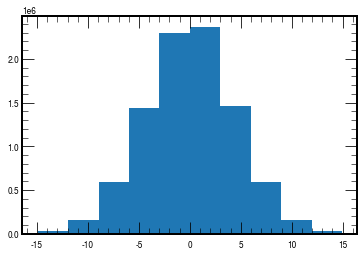

In [67]:
plt.hist(tt["trk_z0"])

(array([  33271.,  157000.,  605595., 1459866., 2358090., 2307900.,
        1445691.,  578496.,  162297.,   36021.]),
 array([-3.41, -2.73, -2.05, -1.36, -0.68, -0.  ,  0.68,  1.36,  2.04,
         2.73,  3.41], dtype=float32),
 <BarContainer object of 10 artists>)

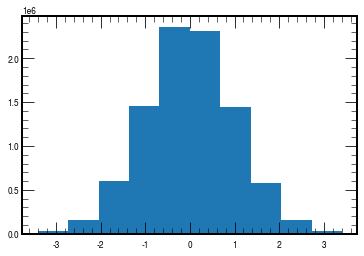

In [68]:
plt.hist(tt["trk_z0_sc"])

(array([759667., 932195., 962842., 940474., 965078., 964033., 948652.,
        974777., 940670., 755839.]),
 array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

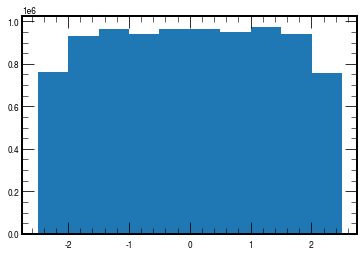

In [69]:
plt.hist(tt["trk_eta"])

(array([759667., 932195., 962842., 940474., 965078., 964033., 948652.,
        974777., 940670., 755839.]),
 array([-1.81, -1.45, -1.09, -0.73, -0.36, -0.  ,  0.36,  0.72,  1.08,
         1.44,  1.81], dtype=float32),
 <BarContainer object of 10 artists>)

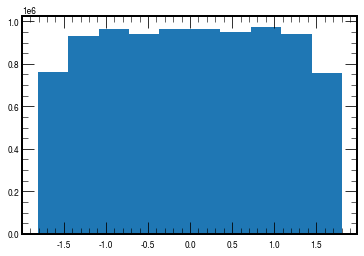

In [71]:
plt.hist(tt["trk_eta_sc"])

(array([917266., 910858., 915770., 914825., 915190., 917984., 915818.,
        915536., 909055., 911925.]),
 array([-1.73, -1.38, -1.04, -0.69, -0.35,  0.  ,  0.35,  0.69,  1.04,
         1.39,  1.73], dtype=float32),
 <BarContainer object of 10 artists>)

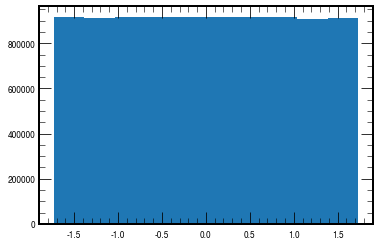

In [72]:
plt.hist(tt["trk_phi_sc"])